In [1]:
import os
import requests
from dotenv import load_dotenv

from langchain_openai import AzureChatOpenAI
# from openai import AzureOpenAI

# from langchain.chat_models import init_chat_model

from langchain.tools import tool
from langchain.agents import create_agent

pwd = %pwd
env_path = os.path.join(pwd,'.env')

load_dotenv(env_path)


/mnt/custom-file-systems/efs/fs-0713103aada1ad94d_fsap-03d52ef0d5b91b6d3/LLM-World/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
os.getenv('AZURE_OPENAI_BASEURL')

'https://bms-openai-proxy-eus-prod.azu.bms.com/openai-urls.json'

In [3]:
# response = requests.get(os.getenv('AZURE_OPENAI_BASEURL'))
# response.json()['nonprod'].keys()
# response.json()['nonprod']['dall-e-3']


In [4]:
response = requests.get(os.getenv('AZURE_OPENAI_BASEURL'))

model_endpoint = {}
for obj_name in response.json()['nonprod']:
    model_endpoint[response.json()['nonprod'][obj_name][0]['deployment_name']]=response.json()['nonprod'][obj_name][0]['endpoint']

model_endpoint.keys()

dict_keys(['dall-e-3', 'gpt-4.1', 'gpt-4.1-mini', 'gpt-4.1-nano', 'gpt-4o-audio-preview', 'gpt-4o-global', 'gpt-4o-mini-global', 'gpt-4o-regional', 'gpt-5', 'gpt-5-chat', 'gpt-5-mini', 'gpt-5-nano', 'gpt-5.1', 'gpt-5.1-chat', 'gpt-audio', 'gpt-audio-mini', 'gpt-image-1', 'gpt-image-1-mini', 'model-router', 'o1', 'o3', 'o3-mini', 'o4-mini', 'text-embedding-3-large', 'text-embedding-3-small', 'text-embedding-ada-002'])

In [5]:
model_endpoint['gpt-4.1']

'https://bms-openai-services-australiaeast-1-nonprod.azu.bms.com'

In [6]:
modle_id = 'gpt-4.1'
model = AzureChatOpenAI(
    deployment_name=modle_id,  
    openai_api_version="2025-03-01-preview",
    # openai_api_version="2024-12-01-preview",
    azure_endpoint=model_endpoint['gpt-4.1'],
    api_key=os.getenv('AZURE_OPENAI_KEY'),
    temperature=0)
    


In [7]:
model

AzureChatOpenAI(profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x7f8484a4ced0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7f84844d0f90>, root_client=<openai.lib.azure.AzureOpenAI object at 0x7f85c02d8e50>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x7f8484a12c90>, temperature=0.0, model_kwargs={}, stream_usage=True, disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://bms-openai-services-australiaeast-1-nonprod.azu.bms.com', deployment_name='gpt-4.1', openai_api_version='2025-

In [8]:
@tool
def create_calendar_event(
    title:str,
    start_time:str,
    end_time:str,
    atendees:list[str],
    location:str=""
) -> str:
    """create calendar event"""
    return f"Created event: {title} from {start_time} to {end_time} with {len(atendees)} atendees."

@tool
def send_email(
    to:list[str],
    subject:str,
    body:str,
    cc:list[str]
) -> str:
    """send an email via api"""
    return f"Email sent to {','.join(to)} - Subject: {subject}"


@tool
def get_available_time_slots(
    atendees:list[str],
    date:str,
    duration_minutes:int,
)-> list[str]:
    """Check calendar availability for a given atendee on a specific date"""
    return ["09:00","14:00","16:00"]

In [9]:
CALENDAR_AGENT_PROMPT = (
    "You are a calendar scheduling assistant. "
    "Parse natural language scheduling requests (eg, 'next Tuesday at 2pm') "
    "into proper ISO datetime formats. "
    "Use get_available_time_slots to check availability when needed. "
    "Use create_calendar_event to schedule events. "
    "Always confirm what was scheduled in your final response. "
)



calendar_agent = create_agent(
    model,
    tools=[create_calendar_event, get_available_time_slots],
    system_prompt=CALENDAR_AGENT_PROMPT
)

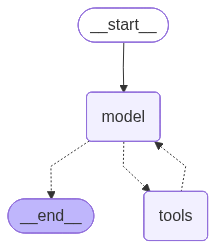

In [10]:
calendar_agent

In [11]:
## test agent

query = "Schedule a team meeting next Tuesday at 2pm for 1 hour"

## surface real-time response from agent
for step in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    #stream_mode="updates" #emits an event after every step
):
    print(step.values())

dict_values([{'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 178, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-Cj85LZCxL1Swg3D9IskeVqmgJTbZH', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='lc_run--0b28c86f-4fa3-495b-a526-fe7424023088-0', tool_calls=[{'name': 'get_available_ti

In [19]:
## test agent

query = "Schedule a team meeting next Tuesday at 2pm for 1 hour"

## surface real-time response from agent (progress, intermediate steps, partial responses as they are generated)
for step in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    #stream_mode="updates" #emits an event after every step
):
    # print(step.values())
    for update in step.values():
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_available_time_slots (call_QpBfmFPL1h8MvHdlV2vKNRi2)
 Call ID: call_QpBfmFPL1h8MvHdlV2vKNRi2
  Args:
    atendees: []
    date: 2024-06-18
    duration_minutes: 60
================================= Tool Message =================================
Name: get_available_time_slots

["09:00", "14:00", "16:00"]
================================== Ai Message ==================================
Tool Calls:
  create_calendar_event (call_IhumsFLG78td0Hr4t5rkaNou)
 Call ID: call_IhumsFLG78td0Hr4t5rkaNou
  Args:
    title: Team Meeting
    start_time: 2024-06-18T14:00:00
    end_time: 2024-06-18T15:00:00
    atendees: []
================================= Tool Message =================================
Name: create_calendar_event

Created event: Team Meeting from 2024-06-18T14:00:00 to 2024-06-18T15:00:00 with 0 atendees.
================================== Ai Message ==================================

The

In [20]:
for chunk in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    stream_mode="updates" #emits an event after every step
):
    print(chunk.items())

dict_items([('model', {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 178, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-Cj89kfGE5NVIFSegA56a79AtXzZSi', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='lc_run--a88e5ef8-0b92-4a0a-84f6-c9745fdb3a9c-0', tool_calls=[{'name': 'get_ava

In [26]:
for chunk in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    stream_mode="updates" #emits an event after every step
):

    for step, data in chunk.items():
        print(f"steps: {step}")
        print(f"content: {data['messages'][-1].content_blocks}")

steps: model
content: [{'type': 'tool_call', 'name': 'get_available_time_slots', 'args': {'atendees': [], 'date': '2024-06-18', 'duration_minutes': 60}, 'id': 'call_TNLVsK4MAr5ySBoWUt9GQYHx'}]
steps: tools
content: [{'type': 'text', 'text': '["09:00", "14:00", "16:00"]'}]
steps: model
content: [{'type': 'tool_call', 'name': 'create_calendar_event', 'args': {'title': 'Team Meeting', 'start_time': '2024-06-18T14:00:00', 'end_time': '2024-06-18T15:00:00', 'atendees': []}, 'id': 'call_cuyzKSa8VcMFIJ1UeZK2fUXb'}]
steps: tools
content: [{'type': 'text', 'text': 'Created event: Team Meeting from 2024-06-18T14:00:00 to 2024-06-18T15:00:00 with 0 atendees.'}]
steps: model
content: [{'type': 'text', 'text': 'The team meeting has been scheduled for next Tuesday, June 18th, from 2:00 PM to 3:00 PM. If you would like to add attendees or a location, please let me know!'}]


In [27]:
for chunk in calendar_agent.stream(
    {"messages":[{"role":"user","content":query}]}, 
    stream_mode="updates" #emits an event after every step
):

    for step, data in chunk.items():
        print(f"steps: {step}")
        print(f"content: {data['messages'][-1].content}")

steps: model
content: 
steps: tools
content: ["09:00", "14:00", "16:00"]
steps: model
content: 
steps: tools
content: Created event: Team Meeting from 2024-06-18T14:00:00 to 2024-06-18T15:00:00 with 0 atendees.
steps: model
content: The team meeting has been scheduled for next Tuesday, June 18th, from 2:00 PM to 3:00 PM. Please let me know if you would like to add specific attendees or a location.


In [13]:
## final answer w/o realtime feedback
response = calendar_agent.invoke({"messages":[{"role":"user","content":query}]})
response

{'messages': [HumanMessage(content='Schedule a team meeting next Tuesday at 2pm for 1 hour', additional_kwargs={}, response_metadata={}, id='b64c462b-b51a-4f94-b1cf-39fd6a2805e2'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 178, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-Cj85SL7xhMfsoM96t7HwolCFTbEnv', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason'

In [14]:
# response['messages'][-1].content
response['messages'][-1].text

'The team meeting has been scheduled for next Tuesday, June 18th, from 2:00 PM to 3:00 PM. Please let me know if you would like to add attendees or a location to this event.'

In [15]:
## eamil agent

EMAIL_AGENT_PROMPT = (
    "You are an email assitant. "
    "Compose professional emails based on natural language requests. "
    "Extract recipient information and craft apropriate subject lines and body text. "
    "Use send_email to send the message. "
    "Always confirm what was sent in your final response. "
)

email_agent = create_agent(
    model,
    tools=[send_email],
    system_prompt=EMAIL_AGENT_PROMPT
)

In [16]:
query = "send the design team a reminder about reviewing the new mock"

for step in email_agent.stream({"messages": [{"role":"user", "content":query}]}):
    for update in step.values():
        for message in update.get("messages",[]):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  send_email (call_YK8G2m8jCe94jFqA4FoRCP6m)
 Call ID: call_YK8G2m8jCe94jFqA4FoRCP6m
  Args:
    to: ['design-team@example.com']
    subject: Reminder: Please Review the New Mock
    body: Hello Design Team,

This is a friendly reminder to review the new mock. Your feedback is important to ensure we are aligned before moving forward.

Please take a moment to review it at your earliest convenience and share your thoughts.

Thank you!

Best regards,
[Your Name]
    cc: []
================================= Tool Message =================================
Name: send_email

Email sent to design-team@example.com - Subject: Reminder: Please Review the New Mock
================================== Ai Message ==================================

I have sent a reminder email to the design team asking them to review the new mock. The subject of the email was "Reminder: Please Review the New Mock." If you need 

In [17]:
response = email_agent.invoke({"messages":[{"role":"user","content":query}]})
response

{'messages': [HumanMessage(content='send the design team a reminder about reviewing the new mock', additional_kwargs={}, response_metadata={}, id='c6baa919-a0b8-49d9-8c56-13634b1aa7cb'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 115, 'total_tokens': 219, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_f99638a8d7', 'id': 'chatcmpl-Cj85Z2H7aNqLxk9gPfkzVgw7VooL1', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_

In [18]:
response['messages'][-1].content
# response['messages'][-1].text

"I've sent a reminder email to the design team asking them to review the new mock. If you need any further follow-up or want to include additional details, please let me know!"

#### Wrap subagent as a tool for supervisor to call

In [28]:
@tool
def schedule_event(request: str) -> str:
    """Schedule calendar events using natural language.

    Use this when the user wants to create, modify or check calendar appointments.
    Handles date/time parsing, availability checking, and event creation.


    Input: Natural language scheduling request (e.g., 'meeting with design team next Tuesday at 2pm')
    """
    result = calendar_agent.invoke({
        "messages":[{"role":"user", "content":request}]
        })
    return result['messages'][-1].content


@tool
def manage_email(request: str) -> str:
    """ Send emails using natural language.

    Use this when the user wants to send notifications, reminders, or any
    communication. Handles recipient extraction, subject generation, and email composisiton.

    Input: Natural language email request (e.g., 'send time reminder about the meeting' )
    """
    result = email_agent.invoke({
        "messages":[{"role":"user", "content":request}]
    })
    return result['messages'][-1].text
    

##### Supervisor Agent

In [31]:
SUPERVISOR_PROMPT = (
    "You are a helpful personal assistant. "
    "You can schedule calendar events and send emails. "
    "Break down uer requests into appropriate tool calls and coorddinate the results. "
    "When a request involves multiple actions, use multiple tools in sequence. "
)

supervisor_agent = create_agent(
    model,
    tools=[schedule_event, manage_email],
    system_prompt=SUPERVISOR_PROMPT
)